# Transfer Learning
## Images

We will make use of transfer learning to create a simple neural network that can recognize types of food. We will use only some pictures of the database [Food Images](https://www.kaggle.com/kmader/food41).

We will make use of the MobileNet, which is built into Keras.  We will begin by loading the entire MobileNet and seeing how well it classifies with several test images.  MobileNet can classify 1,000 different images.  We will ultimatly extend it to classify image types that are not in its dataset, in this example 3 dishes.  However, we begin by classifying image types amoung those that it was trained on.  Even though our test images were not in its training set, the loaded neural network should be able to classify them.

In [0]:
import pandas as pd
import numpy as np
import os
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Download weights for a MobileNet trained for the imagenet dataset. 

In [2]:
model = MobileNet(weights='imagenet',include_top=True)

17227776/17225924 [==============================] - 0s 0us/step


The loaded network is a Keras neural network. However, this was trained on advanced hardware. Look at the structure by summarizing the model.

In [3]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

From the structure, some of the layers have zeros in their number of parameters. Items which are hyperparameters are always zero, nothing about that layer is learned.  The other layers have learnable paramaters that are adjusted as training occurs.  The layer types are all hyperparamaters, Keras will not change a convolution layer to a max pooling layer for you.  However, the layers that have parameters are trained/adjusted by the traning algorithm. Most of the parameters seen above are the weights of the neural network.

Some of the parameters are maked as non-trainable.  These cannot be adjusted by the training algorithm.  When we later use transfer learning with this model we will strip off the final layers that classify 1000 items and replace with our 3 dishes classification layer.  Only our new layers will be trainable, we will mark the existing layers as non-trainable.

The Relu activation function is used throught the neural network.  Also batch and dropout normalization are used. Many deep neural networks are pyramid shaped, and this is the case for this one.  This neural network uses and expanding pyramid shape as you can see the neuron/filter counts expand from 32 to 64 to 128 to 256 to 512 and max out at 1,024.

We will now use the MobileNet to classify several image URL's below.  You can add additional URL's of your own to see how well the MobileNet can classify.

'___________________________________________________________________________________________'

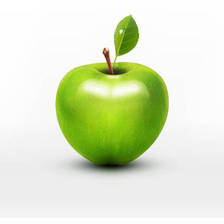

[948]
40960/35363 [==================================] - 0s 0us/step
('n07742313', 'Granny_Smith', 0.99821585)
('n02948072', 'candle', 0.0008299736)
('n07720875', 'bell_pepper', 0.00062787323)
('n04380533', 'table_lamp', 9.8343364e-05)
('n12057211', "yellow_lady's_slipper", 4.2163527e-05)


'___________________________________________________________________________________________'

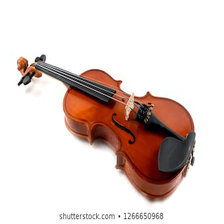

[889]
('n04536866', 'violin', 0.9863556)
('n02992211', 'cello', 0.012652585)
('n04090263', 'rifle', 0.00047945292)
('n02749479', 'assault_rifle', 0.00030835238)
('n02676566', 'acoustic_guitar', 5.999615e-05)


'___________________________________________________________________________________________'

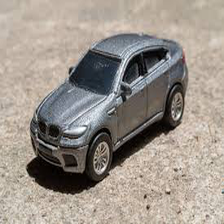

[436]
('n02814533', 'beach_wagon', 0.7960535)
('n04285008', 'sports_car', 0.058824368)
('n02974003', 'car_wheel', 0.038901344)
('n03670208', 'limousine', 0.012066197)
('n03100240', 'convertible', 0.009852247)


'___________________________________________________________________________________________'

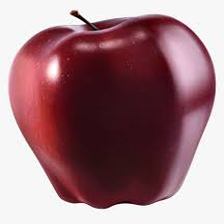

[945]
('n07720875', 'bell_pepper', 0.99897754)
('n07742313', 'Granny_Smith', 0.00020584074)
('n03786901', 'mortar', 0.00014961616)
('n04579145', 'whiskey_jug', 0.0001196936)
('n07717410', 'acorn_squash', 5.181895e-05)


In [4]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

images = [
    "https://us.123rf.com/450wm/alkestida/alkestida1510/alkestida151000004/47412317-stock-vector-vector-green-apple-with-green-leaf-isolated-on-a-white-background.jpg?ver=6",
    "https://image.shutterstock.com/image-photo/violin-viola-put-on-white-260nw-1266650968.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRb1ec42eWW8nQLU17I7oU7JiAUo7eYKjVNXjKuKS5kQaw613AF&usqp=CAU",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTJGvXiArEqHQ_KfM5nxr1E4QuXLoxhy7eT5b48nBA-IH9xfso1&usqp=CAU"
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
        
for url in images:
    x = []
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    
    display("___________________________________________________________________________________________")
    display(img)
    print(np.argmax(pred,axis=1))

    lst = decode_predictions(pred, top=5)
    for itm in lst[0]:
        print(itm)

Overall, the neural network is doing quite well.  However, it does not classify the apple as an "apple", rather it is classified as a "bell_pepper".  This is likely because of the shape of this apple. 

MobileNet might be entirely acceptable as an image classifier for many applications.  However, if you need to classify very specialized images that are not in the 1,000 image types supported by imagenet, it is necessary to use **transfer learning**.

## **Transfer**

Create your own image classification network from scratch would take considerable time and resources. By using a pre-trained neural network, you are taking advantage of the knowledge already built into the lower layers of the neural network.  The transferred layers likely already have some notion of shapes, ingredients, etc.  These lower-level concepts help to train the neural network to identify dishes.

Next we reload the MobileNet; however, this time we set the *include_top* parameter to *False*. This instructs Keras to not load the final classification layers.  This is the common mode of operation for transfer learning.  We display a summary to see that the top classification layer is now missing.

In [5]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model=MobileNet(weights='imagenet',include_top=False) 

base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________

Add new top layers to the neural network.  Our final SoftMax layer includes support for 3 classes.


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
preds=Dense(3,activation='softmax')(x) 

Mark the origional MobileNet layers as non-trainable and our new layers as trainable.

In [0]:
model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

To train the neural network we must create a directory structure to hold the images.  The Keras command **flow_from_directory** performs this for us.  It requires that in a folder of classes each class is a folder that contains images of that class (a folder of folders).  We can also specify a target size, in this case the origional MobileNet size of 224x224 is desired.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/Colab Notebooks/TransferLearning/DBfood/', 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 21 images belonging to 3 classes.


We are now ready to compile and fit the neural network.  Notice we are using **fit_generator** rather than **fit**.  This is because we are using the convienent **ImageDataGenerator**.

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=20)

Epoch 1/20
21/21 [==============================] - 9s 438ms/step - loss: 1.4037 - accuracy: 0.4286
Epoch 2/20
21/21 [==============================] - 3s 158ms/step - loss: 1.0569 - accuracy: 0.4762
Epoch 3/20
21/21 [==============================] - 3s 160ms/step - loss: 0.8466 - accuracy: 0.5714
Epoch 4/20
21/21 [==============================] - 3s 159ms/step - loss: 0.5296 - accuracy: 0.8095
Epoch 5/20
21/21 [==============================] - 3s 159ms/step - loss: 0.5542 - accuracy: 0.7619
Epoch 6/20
21/21 [==============================] - 3s 159ms/step - loss: 0.6763 - accuracy: 0.7143
Epoch 7/20
21/21 [==============================] - 3s 160ms/step - loss: 0.5037 - accuracy: 0.7143
Epoch 8/20
21/21 [==============================] - 3s 159ms/step - loss: 0.4925 - accuracy: 0.7619
Epoch 9/20
21/21 [==============================] - 3s 157ms/step - loss: 0.2687 - accuracy: 0.9048
Epoch 10/20
21/21 [==============================] - 3s 161ms/step - loss: 0.1358 - accuracy: 0.9048

We are now ready to see how our new model can predict dishes. 


'___________________________________________________________________________________________'

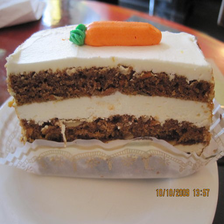

[2]


'___________________________________________________________________________________________'

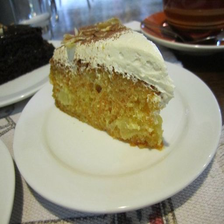

[2]


'___________________________________________________________________________________________'

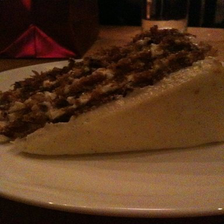

[1]


'___________________________________________________________________________________________'

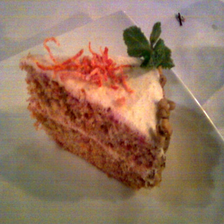

[0]


'___________________________________________________________________________________________'

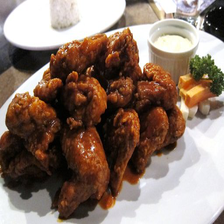

[1]


'___________________________________________________________________________________________'

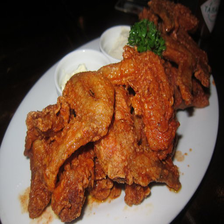

[1]


'___________________________________________________________________________________________'

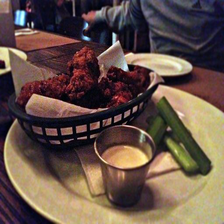

[1]


'___________________________________________________________________________________________'

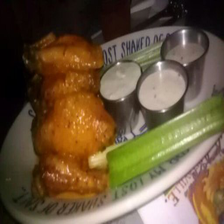

[1]


'___________________________________________________________________________________________'

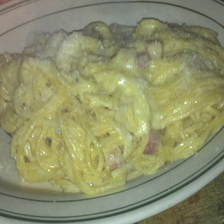

[2]


'___________________________________________________________________________________________'

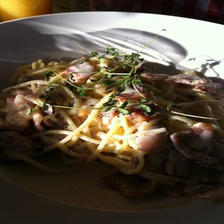

[2]


'___________________________________________________________________________________________'

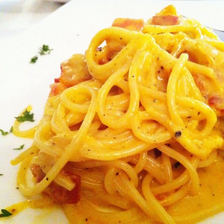

[2]


'___________________________________________________________________________________________'

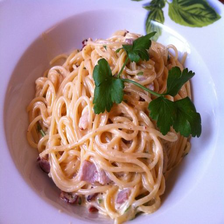

[2]


In [0]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
from tensorflow.keras.applications.mobilenet import decode_predictions

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

images = ["/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-a-test/37787.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-a-test/109681.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-a-test/158787.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-a-test/164347.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-b-test/1537413.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-b-test/1537867.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-b-test/1538012.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-b-test/1543000.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-c-test/365217.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-c-test/363243.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-c-test/359437.jpg",
          "/content/drive/My Drive/Colab Notebooks/TransferLearning/test/clase-c-test/349084.jpg"
]




def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
        
for path in images:
    x = []
    img = Image.open(path)
    img.load()
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT),Image.ANTIALIAS)
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    
    display("___________________________________________________________________________________________")
    display(img)
    print(np.argmax(pred,axis=1))
